In [ ]:
# import packages needed for entire model

import tensorflow as tf
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from keras.backend import softsign
import shutil
import random
from keras import metrics
import sys
import h5py

# mount to google drive in order to pull data file
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
terminal = sys.stdout

Mounted at /content/drive


In [ ]:
# import data file, splice data, split into testing and training data
subsetSize=10000
splicingVal = 11
numOutputs = int(220/splicingVal)

file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
sample = hf["sample_id"][0:subsetSize]
imgs = hf['images'][0:subsetSize]
spectra = hf['spectra'][0:subsetSize]
spectra = np.array([x[::splicingVal] for x in spectra])
x_train, x_test, y_train, y_test = train_test_split(imgs, spectra, test_size = 0.2, random_state = None)

In [ ]:
# Old Neural Network Model function


def get_conv_model_normal():

    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(units=numOutputs, activation = None)])
    model.summary()
    model.compile(optimizer='sgd', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [ ]:
# Current Neural Network Model function

def get_conv_model_normal():

    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(units=numOutputs, activation = 'softsign')])
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [ ]:
# Running Neural Network with averaging Ensemble 

# define variables, number of batches and epochs
sys.stdout = open('EpochOutput.txt', 'w') 
numNetworks = 1
modelList = []
historyList= []
epochs = 100
batch_size = 10

# Run Neural Network for the desired number of networks in the ensemble (numNetworks)
for i in range(numNetworks):
  normal_model = get_conv_model_normal()
  normal_history = normal_model.fit(x_train, y_train, batch_size = batch_size,
                epochs = epochs, validation_data = (x_test, y_test), verbose = 1)
  modelList.append(normal_model)
  historyList.append(normal_history)

# Create predictions based on results of the neural network and ensemble 
def makePredictionsList(modelList, data):
  return [model.predict(data) for model in modelList]

# Create the geometric average of the output spectra from the predicted values from the ensemble
def ensemblePredictGeoAverage(predictList, ele):
  numNetworks = len(predictList)
  prediction = 1
  for predict in predictList:
    prediction *= np.abs(predict[ele])
  return prediction**(1/numNetworks)

In [ ]:
# DO NOT RUN
# Attempted neural network for the outcomes of the ensemble, returned bad graphs so scratched for now, may implement later

def get_model_from_ensemble():
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (numNetworks, numOutputs)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(units=20, activation='softsign')
    ])
    model.summary()
    model.compile(loss = tf.keras.losses.MeanSquaredLogarithmicError(), optimizer = 'adam', metrics = [metrics.mean_squared_logarithmic_error, metrics.mean_absolute_percentage_error]))
    return model

# fixed input parameters
modelInput = makePredictionsList(modelList, imgs)
modelInput = np.transpose(modelInput, (1, 0, 2))

sys.stdout = open('EpochOutput2.txt', 'w') 
epochs = 50
batch_size = 32
x_train2, x_test2, y_train2, y_test2 = train_test_split(modelInput, spectra, test_size = 0.2, random_state = None)
final_model = get_model_from_ensemble()
final_history = final_model.fit(x_train2, y_train2, batch_size = batch_size,
              epochs = epochs, validation_data = (x_test2, y_test2), verbose = 1)
sys.stdout = terminal

# Plots to visualize the mean squared logarithmic error and mean absolute percentage error of our final neural network ensemble model

# MSLE
plt.plot(final_history.history['mean_squared_logarithmic_error'], label='MSLE training data')
plt.plot(final_history.history['val_mean_squared_logarithmic_error'], label='MSLE validation data')
plt.legend()
plt.title('Mean Squared Logarithmic Error Over Time')
plt.ylabel('MSLE')
plt.xlabel('epoch')
plt.savefig('ModelAccuracyMSLE.jpg')
plt.show()

# MAPE
plt.plot(final_history.history['mean_absolute_percentage_error'], label='MAPE training data')
plt.plot(final_history.history['val_mean_absolute_percentage_error'], label='MAPE validation data')
plt.legend()
plt.title('Mean Absolute Percentage Error Over Time')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.savefig('ModelAccuracyMAPE.jpg')
plt.show()

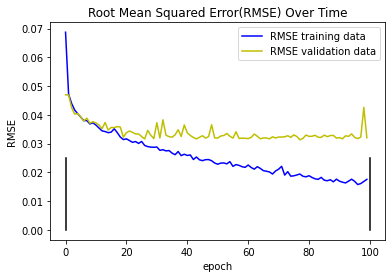

In [ ]:
# Plots to visualize the root mean squared error and mean absolute percentage error of our neural network ensemble model

# RMSE
for i, normal_history in enumerate(historyList):
  x = np.array([x for x in range(epochs)])
  plt.plot(x + epochs*i, normal_history.history['root_mean_squared_error'], color = 'b')
  plt.plot(x + epochs*i, normal_history.history['val_root_mean_squared_error'], color = 'y')
  plt.plot([epochs*(i+1),epochs*(i+1)],[0,.025], color='black')
  plt.title('Root Mean Squared Error(RMSE) Over Time')
  plt.ylabel('RMSE')
  plt.xlabel('epoch')
  plt.savefig('ModelAccuracyRMSE.jpg')
plt.legend(['RMSE training data', 'RMSE validation data'])
plt.plot([0,0],[0,.025], color = 'black')
plt.show()

# MAPE
# for i, normal_history in enumerate(historyList):
#  x = np.array([x for x in range(epochs)])
#  plt.plot(x + epochs*i, normal_history.history['mean_absolute_percentage_error'], label='MAPE training data', color = 'b')
#  plt.plot(x + epochs*i, normal_history.history['val_mean_absolute_percentage_error'], label='MAPE validation data', color = 'y')
#  plt.plot([epochs*(i+1),epochs*(i+1)],[0,300], color='black')
#  plt.legend()
#  plt.title('Mean Absolute Percentage Error(MAPE) Over Time')
#  plt.ylabel('MAPE')
#  plt.xlabel('epoch')
#  plt.savefig('ModelAccuracyMAPE.jpg')
# plt.legend(['MAPE training data', 'MAPE validation data'])
# plt.plot([0,0],[0,300], color = 'black')
# plt.show()

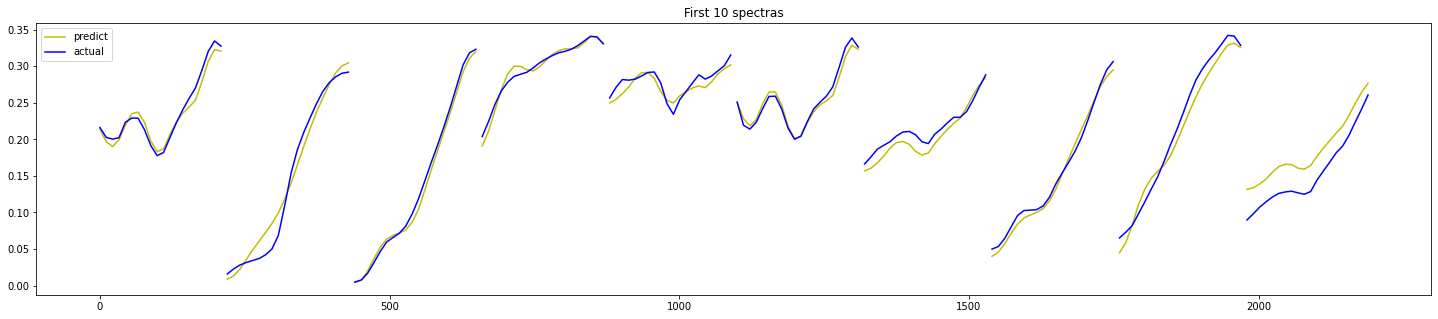

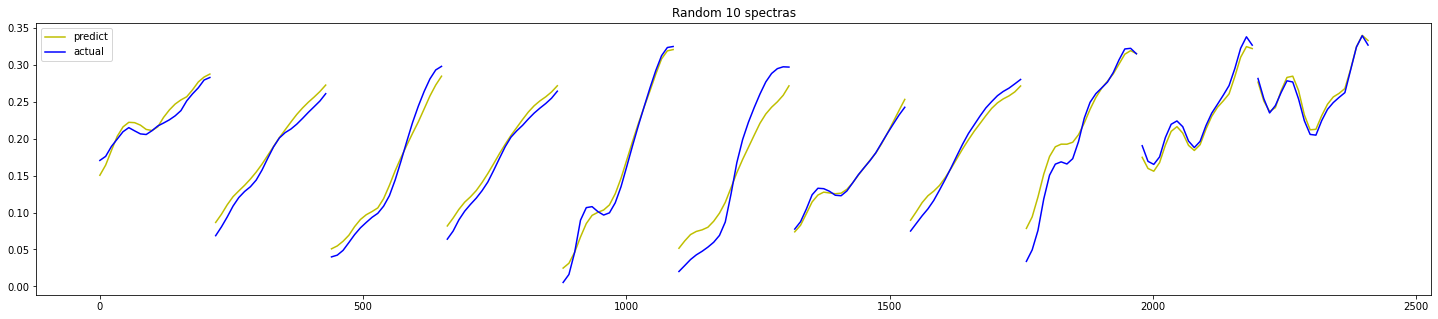

In [ ]:
# Plots first 10 spectra images on a single graph

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_train)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_train))]
fig = plt.figure(figsize=(25, 5))
for i in range(10):
  plt.plot(x + 220*i, y[i] , color = 'y')
  plt.plot(x + 220*i, y_train[i], color = 'b')
  plt.legend(['predict', 'actual'], loc='upper left')
plt.title('First 10 spectras')
plt.savefig('First10.jpg')
plt.show()

# Plots random 100 spectra images on a single graph
rando = [x for x in range(10, len(y))]
random.shuffle(rando)
i = 0
fig = plt.figure(figsize=(25, 5))
for rand in rando:
  if i > 10:
    break
  plt.plot(x + 220*i, y[rand], color = 'y')
  plt.plot(x + 220*i, y_train[rand], color = 'b')
  plt.legend(['predict', 'actual'], loc='upper left')
  i+=1
plt.title('Random 10 spectras')
plt.savefig('Random10.jpg')
plt.show()

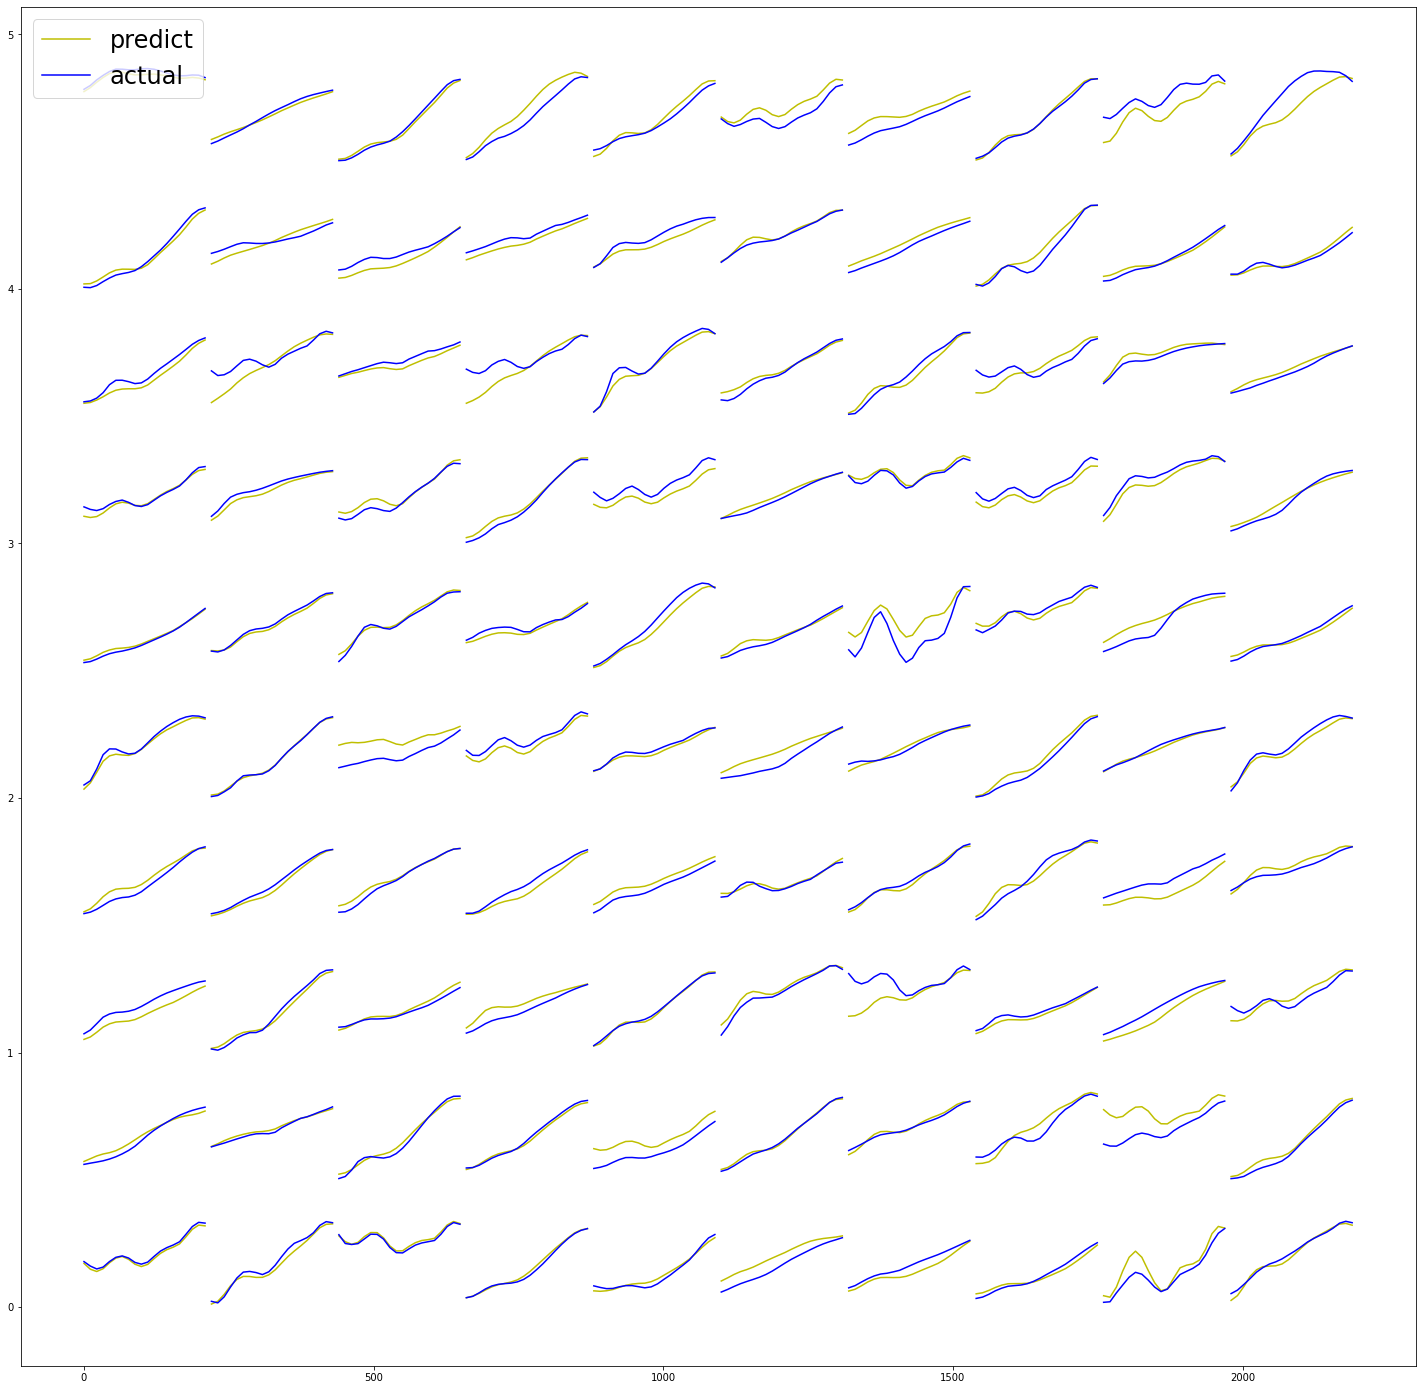

In [ ]:
def closest_factor(num):
  n = int(np.sqrt(num))
  if num % n == 0:
    return n
  else:
    n+=1
    while num % n != 0:
      n+=1
    return int(num/n), n

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_test)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_test))]
fig = plt.figure(figsize=(25, 25))
low, high = closest_factor(len(x_test))
for j in range(10):
  for i in range(10):
    plt.plot(x + 220*i, y[50*j+i]+.5*j, color = 'y')
    plt.plot(x + 220*i, y_test[50*j+i]+.5*j, color = 'b')
plt.legend(['predict', 'actual'], loc='upper left', prop={'size': 24})
plt.savefig('100Grid.jpg')
plt.show()

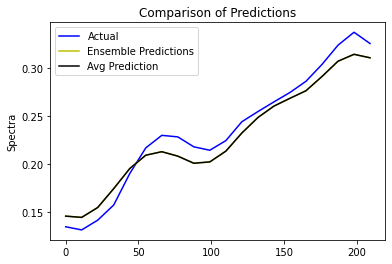

In [ ]:
x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_train)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_train))]
plt.plot(x,y_train[72], color = 'b')
for predict in predictList:
  plt.plot(x, predict[72], color = 'y')
  plt.plot(x,y[72], color = 'black')
plt.legend(['Actual', 'Ensemble Predictions', 'Avg Prediction'], loc = 'upper left')
plt.title('Comparison of Predictions')
plt.ylabel('Spectra')
plt.savefig('PredictCompare.jpg')
plt.show()

In [ ]:
# DO NOT RUN
# Plots First 10 predictions all on the same graph
# Only use if you need to investigate oscillations in spectra graphs
# Must add 'AllPredictions.jpg' to saving code block for this image to save

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_train)
y = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_train))]
fig = plt.figure(figsize=(25, 5))
for i in range(10):
  plt.plot(x, y[i] , color = 'y')    
  plt.legend(['predict'], loc='upper left')  
plt.savefig('AllPredictions.jpg')
plt.show()

InternalError: ignored

In [ ]:
# Saving Code Block: uploads models under names to google drive, must move these to the Shared Drive

names = ['EpochOutput.txt', 'First10.jpg', 'Random10.jpg', 'ModelAccuracyRMSE.jpg', 'PredictCompare.jpg', '100Grid.jpg']

for name in names:
  colab_link = name
  gdrive_link = "/content/drive/My Drive/Colab Notebooks"
  shutil.copy(colab_link, gdrive_link)

In [ ]:
# DO NOT RUN
# Attempt to implement Custom Loss Function, still a work in progress

def custom_loss(y_true, y_pred):
  #shape of y_true/y_pred = (batchSize, numOutputs)
  #distance metric
  lossDistance = tf.square(y_pred - y_true)
  return lossDistance
  #smoothness metric
  Deriv2 = 0
  for batch in range(batchSize):
    for i in range(numOutputs):
      if i == numOutputs - 3:
        break
      Deriv2 += 1

def SMU(x,alpha=0.25):
    mu = tf.compat.v1.get_variable('SMU_mu', shape=(),
                       initializer=tf.constant_initializer(1000000),
                       dtype=tf.float32)
    return ((1+alpha)*x + (1-alpha)*x*tf.math.erf(mu*(1-alpha)*x))/2

def SMU1(x,alpha=0.25):
    mu = tf.compat.v1.get_variable('SMU1_mu', shape=(),
                       initializer=tf.constant_initializer(4.352665993287951e-9),
                       dtype=tf.float32)
    return ((1+alpha)*x+tf.math.sqrt(tf.math.square(x-alpha*x)+tf.math.square(mu)))/2

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

#get_custom_objects().update({'SMU': Activation(SMU)}) 
#get_custom_objects().update({'SMU1': Activation(SMU1)}) 

In [ ]:
# DO NOT RUN 
# Use this only if we want to load an already built model
normal_model = load_model('Model.h5')

OSError: ignored